2023-11-16

BBME 520

Assignment 10 part A

Javid Jannat

In [1]:
import numpy as np 
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img
import nibabel as nib
from matplotlib import pyplot as plt
import scipy

brain_data = datasets.fetch_oasis_vbm(n_subjects=100)

output_variable = np.array(brain_data.ext_vars.mf == 'F', dtype= np.short) #gives 1 for females and 0 for males

data_n = output_variable.size
sets_n = 10

input_variables = [None]*sets_n

for i in range(sets_n):

    if not (i==0): # this saves time as we dont need to load all of the sets
        continue

    ROIS = (i+1)*100

    yeo = datasets.fetch_atlas_schaefer_2018(n_rois=ROIS)
    print('%i regions found in this atlas' % (len(np.unique( nib.load(yeo.maps).get_fdata().ravel())) - 1))

    masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
    input_variables[i] = masker.fit_transform(brain_data.gray_matter_maps)

input_variable =  input_variables[0][:,:50]

C:\Users\Javid\AppData\Roaming\Python\Python311\site-packages\nilearn\input_data\__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
C:\Users\Javid\AppData\Roaming\Python\Python311\site-packages\nilearn\datasets\struct.py:850: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


100 regions found in this atlas


In [2]:
import sklearn
from sklearn import mixture
from sklearn import cluster
import time

p_freq_trainer = sklearn.linear_model.LogisticRegression(penalty='l2',C=1.0 , max_iter= 10000)
p_baye_trainer = sklearn.linear_model.BayesianRidge()

In [15]:
#task 1

degree = 4

out = output_variable

NINETY = int(out.size*0.9)
linspace = np.arange(out.size)
train = linspace < NINETY
test = linspace >= NINETY

outsamp_accuracies = np.zeros((degree))

print('Progress:')

for i in range(degree):
    inp = sklearn.preprocessing.PolynomialFeatures(i+1,include_bias=False).fit_transform(input_variable) #degree 5 is not happening

    model = p_freq_trainer.fit(inp[train],out[train])

    outsamp_accuracies[i] = model.score(inp[test],out[test])

    print('sample ', i+1, ' finished with ', inp.shape[1],' terms')


outsamp_accuracies*= 100

Progress:
sample  1  finished with  50  terms
sample  2  finished with  1325  terms
sample  3  finished with  23425  terms
sample  4  finished with  316250  terms


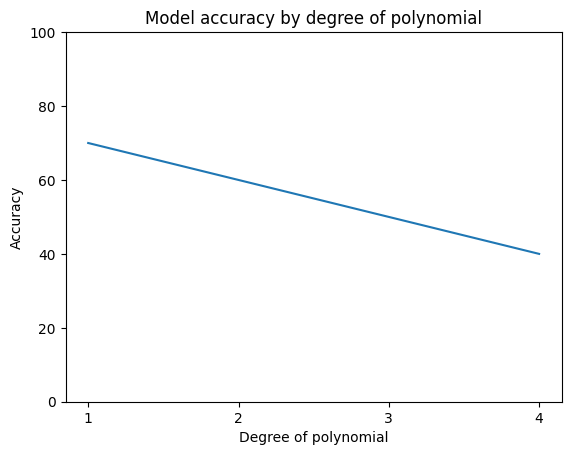

In [16]:
plt.plot(outsamp_accuracies);
plt.xticks(np.arange(outsamp_accuracies.size),np.arange(outsamp_accuracies.size)+1);
plt.xlabel('Degree of polynomial');
plt.ylim([0,100]);
plt.ylabel('Accuracy');
plt.title('Model accuracy by degree of polynomial');

In [5]:
#task 2

degree = 3


out = output_variable

NINETY = int(out.size*0.9)
linspace = np.arange(out.size)
train = linspace < NINETY
test = linspace >= NINETY

outsamp_accuracies = np.zeros((degree))

print('Progress:')

for i in range(degree): 
    inp = sklearn.preprocessing.PolynomialFeatures(i+1,include_bias=False).fit_transform(input_variable)

    model = p_baye_trainer.fit(inp[train],out[train])

    prediction = model.predict(inp[test])
    prediction[prediction<0.5] = 0
    prediction[prediction>=0.5] = 1

    outsamp_accuracies[i] = np.sum(prediction == out[test])/10

    print('sample ', i+1, ' finished with ', inp.shape[1],' terms')


outsamp_accuracies*= 100

Progress:
sample  1  finished with  50  terms
sample  2  finished with  1325  terms
sample  3  finished with  23425  terms


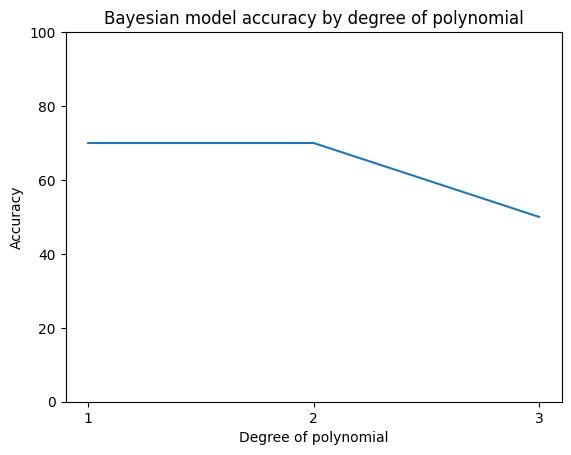

In [6]:
plt.plot(outsamp_accuracies);
plt.xticks(np.arange(outsamp_accuracies.size),np.arange(outsamp_accuracies.size)+1);
plt.xlabel('Degree of polynomial');
plt.ylim([0,100]);
plt.ylabel('Accuracy');
plt.title('Bayesian model accuracy by degree of polynomial');

I get the following error when trying to do degree 4 or higher: 

MemoryError: Unable to allocate 373. GiB for an array with shape (316250, 316250) and data type float32

In [7]:
#task 3

degree = 2
clusters = 20

out = output_variable
poly_inp = sklearn.preprocessing.PolynomialFeatures(degree,include_bias=False).fit_transform(input_variable)

NINETY = int(out.size*0.9)
linspace = np.arange(out.size)
train = linspace < NINETY
test = linspace >= NINETY

outsamp_accuracies = np.zeros((clusters))

print('Progress:',end = ' ')

for i in range(clusters):
    for j in range(20): #we take average over 20 trials with kmeans clustering

        inp = sklearn.cluster.KMeans(i+1, n_init='auto').fit_transform(poly_inp) 

        model = p_freq_trainer.fit(inp[train],out[train])

        outsamp_accuracies[i] += model.score(inp[test],out[test])

    print(i+1,end=' ')
        


outsamp_accuracies*= 5

Progress: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

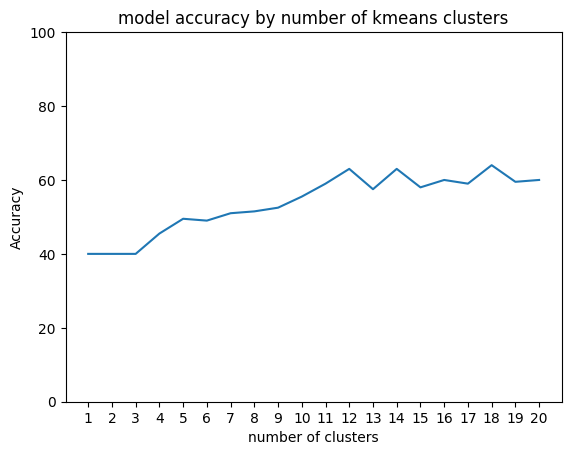

In [8]:
plt.plot(outsamp_accuracies);
plt.xticks(np.arange(outsamp_accuracies.size),np.arange(outsamp_accuracies.size)+1);
plt.xlabel('number of clusters');
plt.ylim([0,100]);
plt.ylabel('Accuracy');
plt.title('model accuracy by number of kmeans clusters');

In [13]:
#task 4

degree = 2
clusters = 20

out = output_variable
poly_inp = sklearn.preprocessing.PolynomialFeatures(degree,include_bias=False).fit_transform(input_variable)

NINETY = int(out.size*0.9)
linspace = np.arange(out.size)
train = linspace < NINETY
test = linspace >= NINETY

outsamp_accuracies = np.zeros((clusters))

print('Progress:',end = ' ')

for i in range(clusters):

    gmm_trainer = sklearn.mixture.GaussianMixture(i+1)

    for j in range(5): #we take average over 5 trials with kmeans clustering, gmm is significantly slower than km clustering

        gmm = gmm_trainer.fit(poly_inp) 
        inp = gmm.predict_proba(poly_inp) 

        model = p_freq_trainer.fit(inp[train],out[train])

        outsamp_accuracies[i] += model.score(inp[test],out[test])

    print(i+1,end=' ')
        

outsamp_accuracies*= 20

Progress: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

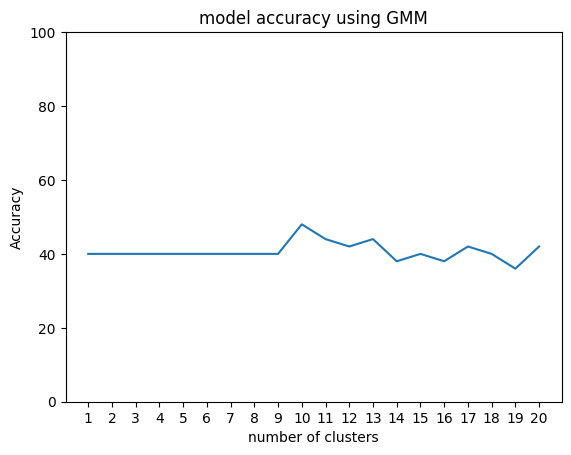

In [14]:
plt.plot(outsamp_accuracies);
plt.xticks(np.arange(outsamp_accuracies.size),np.arange(outsamp_accuracies.size)+1);
plt.xlabel('number of clusters');
plt.ylim([0,100]);
plt.ylabel('Accuracy');
plt.title('model accuracy using GMM');

In [11]:
#task 5

degree = 3

out = output_variable

NINETY = int(out.size*0.9)
linspace = np.arange(out.size)
train = linspace < NINETY
test = linspace >= NINETY

times = np.zeros((degree))

print('Progress:')

for i in range(degree): 
    inp = sklearn.preprocessing.PolynomialFeatures(i+1,include_bias=False).fit_transform(input_variable)

    t_start = time.time()

    model = p_baye_trainer.fit(inp[train],out[train])

    t_end = time.time()

    times[i] = t_end - t_start

    print('sample ', i+1, ' finished with ', inp.shape[1],' terms')

times*= 1000

Progress:
sample  1  finished with  50  terms
sample  2  finished with  1325  terms
sample  3  finished with  23425  terms


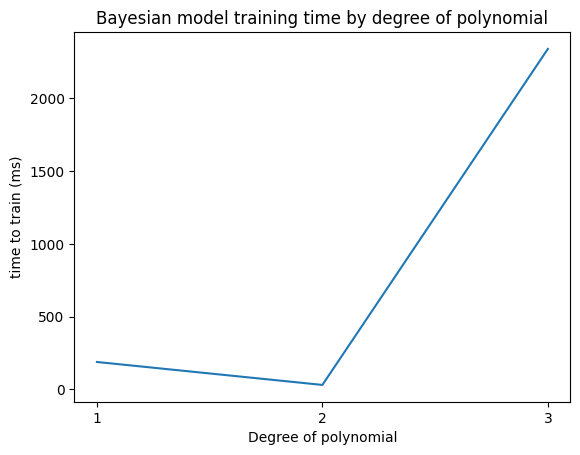

In [12]:
plt.plot(times);
plt.xticks(np.arange(times.size),np.arange(times.size)+1);
plt.xlabel('Degree of polynomial');
plt.ylabel('time to train (ms)');
plt.title('Bayesian model training time by degree of polynomial');

I get the following error when trying to do degree 4 or higher: 

MemoryError: Unable to allocate 373. GiB for an array with shape (316250, 316250) and data type float32